In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import zarr
import dask
from dask.diagnostics import ProgressBar

np.random.seed(42)

In [2]:
# open LLC4320
LLC = xr.open_zarr('/orcd/data/abodner/003/LLC4320/LLC4320',consolidated=False)

In [8]:
# mean and std outs:
mean = {}
std = {}

path = '/orcd/data/abodner/002/cody/LLC_means_stds/'

# --- for season-buckets randomly selected time points:
experiments = [2,4,12,24,48,96] # which experiments to compare! val = num times averaged
for exp, num_time_samples in enumerate(experiments):
    mean[f"exp_{num_time_samples}"] = (xr.open_zarr(f'{path}{num_time_samples}_LLC_means.zarr',consolidated=False))
    std[f"exp_{num_time_samples}"] = (xr.open_zarr(f'{path}{num_time_samples}_LLC_stds.zarr',consolidated=False))

var_test_mean_24 = xr.open_zarr(f'{path}/testing/var_test_LLC_means.zarr', consolidated = False)
var_test_std_24 = xr.open_zarr(f'{path}testing/var_test_LLC_stds.zarr', consolidated = False)

var_test_mean_96 = xr.open_zarr(f'{path}/var_96_LLC_means.zarr', consolidated = False)
var_test_std_96 = xr.open_zarr(f'{path}/var_96_LLC_stds.zarr', consolidated = False)

# --- for randomly sampled time points
mean_ran = {}
std_ran = {}
experiments = [2,4,12,24,48,96] # which experiments to compare! val = num times averaged
for exp, num_time_samples in enumerate(experiments):
    if num_time_samples in [48, 96]:
        mean_ran[f"exp_{num_time_samples}"] = (xr.open_zarr(f'{path}testing/{num_time_samples}_LLC_means.zarr',consolidated=False))
        std_ran[f"exp_{num_time_samples}"] = (xr.open_zarr(f'{path}testing/{num_time_samples}_LLC_stds.zarr',consolidated=False))
    else:
        mean_ran[f"exp_{num_time_samples}"] = (xr.open_zarr(f'{path}testing/theta_eta/{num_time_samples}_LLC_means.zarr',consolidated=False))
        std_ran[f"exp_{num_time_samples}"] = (xr.open_zarr(f'{path}testing/theta_eta/{num_time_samples}_LLC_stds.zarr',consolidated=False)) 


In [9]:
# get depths in meters
depths = []
for d in LLC.Z:
    depths.append(d.values)
depths = np.array(depths)

In [10]:
# get values from ubiquitous and index by depth
def get_val(dict, feature):
    variables_with_feature = [var for var in dict.keys() if f'{feature}' in var]
    # Sort by numeric level index extracted from the key
    variables_with_feature = sorted(
        variables_with_feature,
        key=lambda k: int(k.split('_')[-1]),  # extract 'N' from 'feature_lev_N'
    )

    # Collect values in order
    feature_vals = [dict[k].values for k in variables_with_feature]
    return feature_vals

In [11]:
# grab feature means and stds
def sep_features(means,stds, feature_list):
    mean = {}
    std = {}
    for feature in feature_list:
        feature_mean = {}
        feature_std = {}
        for exp, num_time_samples in enumerate(means):
            feature_mean[f'{num_time_samples}'] = np.array(get_val(means[num_time_samples], feature))
            feature_std[f'{num_time_samples}'] = np.array(get_val(stds[num_time_samples], feature))
        mean[f'{feature}'] = feature_mean
        std[f'{feature}'] = feature_std

    return mean, std

# grab feature means and stds
def sep_features_var(means,stds, feature_list):
    mean = {}
    std = {}
    for feature in feature_list:
        
        feature_mean = np.array(get_val(means, feature))
        feature_std= np.array(get_val(stds, feature))

        mean[f'{feature}'] = feature_mean
        std[f'{feature}'] = feature_std

    return mean, std


In [12]:
feature_list = ['Theta','U_','V_','Salt']
depth_mean, depth_std = sep_features(mean,std, feature_list)

feature_list_ran = ['Theta']
depth_mean_ran, depth_std_ran = sep_features(mean_ran,std_ran, feature_list_ran)

In [13]:
feature_list_var = ['Theta']
depth_mean_var_24, depth_std_var_24 = sep_features_var(var_test_mean_24, var_test_std_24, feature_list_var)
depth_mean_var_96, depth_std_var_96 = sep_features_var(var_test_mean_96, var_test_std_96, feature_list_var)


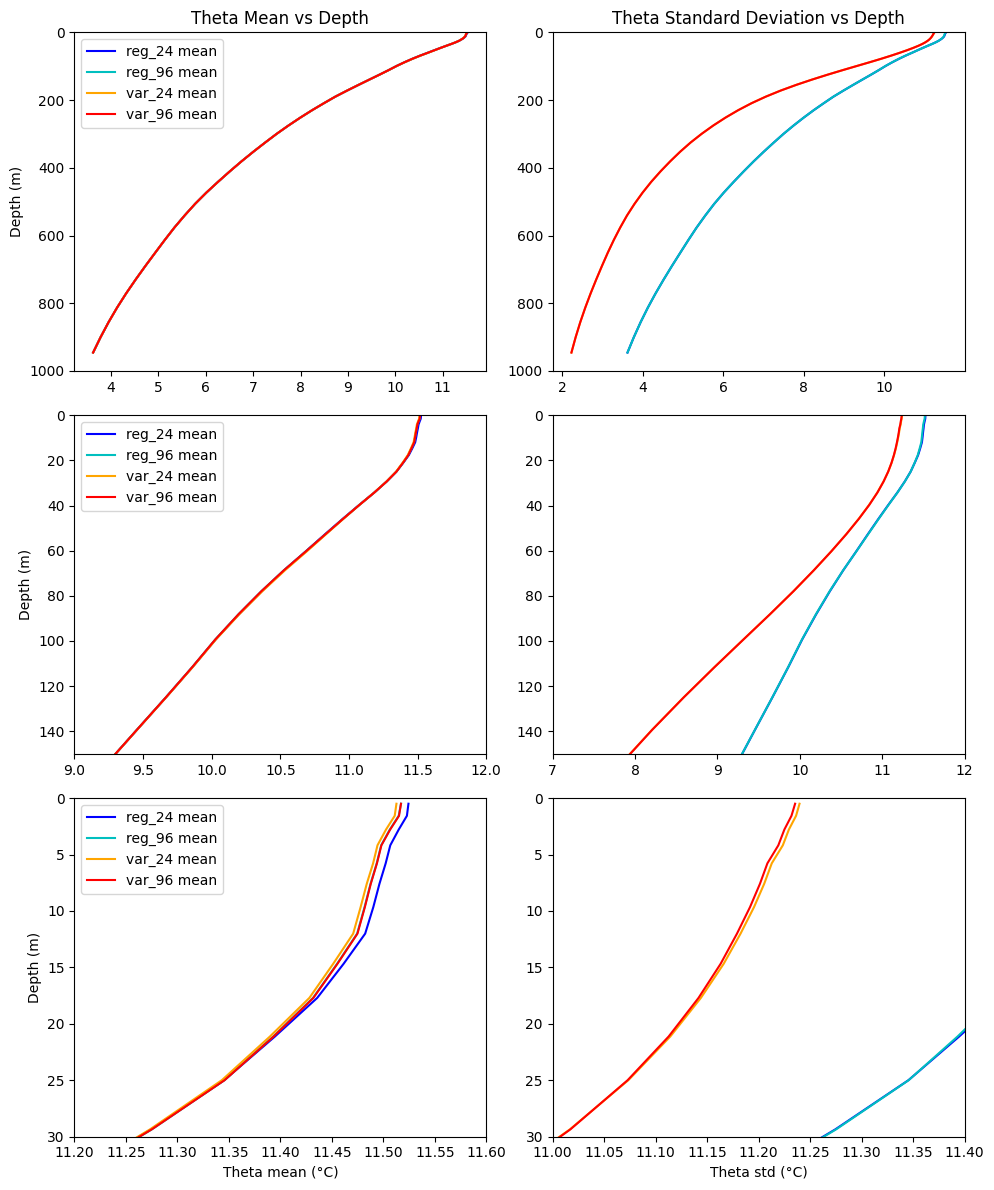

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharey=False)

# --- Plot means ---
axes[0,0].plot(depth_mean['Theta']['exp_24'], np.abs(depths), c='b', label='reg_24 mean')
axes[0,0].plot(depth_mean['Theta']['exp_96'], np.abs(depths), c='c', label='reg_96 mean')
axes[0,0].plot(depth_mean_var_24['Theta'], np.abs(depths), c='orange', label='var_24 mean')
axes[0,0].plot(depth_mean_var_96['Theta'], np.abs(depths), c='r', label='var_96 mean')

axes[0,0].set_ylabel("Depth (m)")
axes[0,0].legend()
axes[0,0].set_title("Theta Mean vs Depth")
axes[0,0].set_ylim(1000,0)

# --- Plot stds ---
axes[0,1].plot(depth_mean['Theta']['exp_24'], np.abs(depths), c='b', label='reg_24 std')
axes[0,1].plot(depth_mean['Theta']['exp_96'], np.abs(depths), c='c', label='reg_96 std')
axes[0,1].plot(depth_std_var_24['Theta'], np.abs(depths), c='orange', label='var_24 std')
axes[0,1].plot(depth_std_var_96['Theta'], np.abs(depths), c='r', label='var_96 std')

axes[0,1].set_title("Theta Standard Deviation vs Depth")
axes[0,1].set_ylim(1000,0)

# zoom 1
# --- Plot means ---
axes[1,0].plot(depth_mean['Theta']['exp_24'], np.abs(depths), c='b', label='reg_24 mean')
axes[1,0].plot(depth_mean['Theta']['exp_96'], np.abs(depths), c='c', label='reg_96 mean')
axes[1,0].plot(depth_mean_var_24['Theta'], np.abs(depths), c='orange', label='var_24 mean')
axes[1,0].plot(depth_mean_var_96['Theta'], np.abs(depths), c='r', label='var_96 mean')

axes[1,0].set_xlim(9,12)
axes[1,0].set_ylabel("Depth (m)")
axes[1,0].set_ylim(150,0)
axes[1,0].legend()

# --- Plot stds ---
axes[1,1].plot(depth_mean['Theta']['exp_24'], np.abs(depths), c='b', label='reg_24 std')
axes[1,1].plot(depth_mean['Theta']['exp_96'], np.abs(depths), c='c', label='reg_96 std')
axes[1,1].plot(depth_std_var_24['Theta'], np.abs(depths), c='orange', label='var_24 std')
axes[1,1].plot(depth_std_var_96['Theta'], np.abs(depths), c='r', label='var_96 std')
axes[1,1].set_xlim(7,12)
axes[1,1].set_ylim(150,0)

# zoom 2
# --- Plot means ---
axes[2,0].plot(depth_mean['Theta']['exp_24'], np.abs(depths), c='b', label='reg_24 mean')
axes[2,0].plot(depth_mean['Theta']['exp_96'], np.abs(depths), c='c', label='reg_96 mean')
axes[2,0].plot(depth_mean_var_24['Theta'], np.abs(depths), c='orange', label='var_24 mean')
axes[2,0].plot(depth_mean_var_96['Theta'], np.abs(depths), c='r', label='var_96 mean')

axes[2,0].set_ylabel("Depth (m)")
axes[2,0].set_xlim(11.2,11.6)
axes[2,0].set_ylim(30,0)
axes[2,0].set_xlabel("Theta mean (°C)")
axes[2,0].legend(loc='upper left')

# --- Plot stds ---
axes[2,1].plot(depth_mean['Theta']['exp_24'], np.abs(depths), c='b', label='reg_24 std')
axes[2,1].plot(depth_mean['Theta']['exp_96'], np.abs(depths), c='c', label='reg_96 std')
axes[2,1].plot(depth_std_var_24['Theta'], np.abs(depths), c='orange', label='var_24 std')
axes[2,1].plot(depth_std_var_96['Theta'], np.abs(depths), c='r', label='var_96 std')

axes[2,1].set_xlim(11, 11.4)
axes[2,1].set_ylim(30,0)
axes[2,1].set_xlabel("Theta std (°C)")

plt.tight_layout()
plt.show()

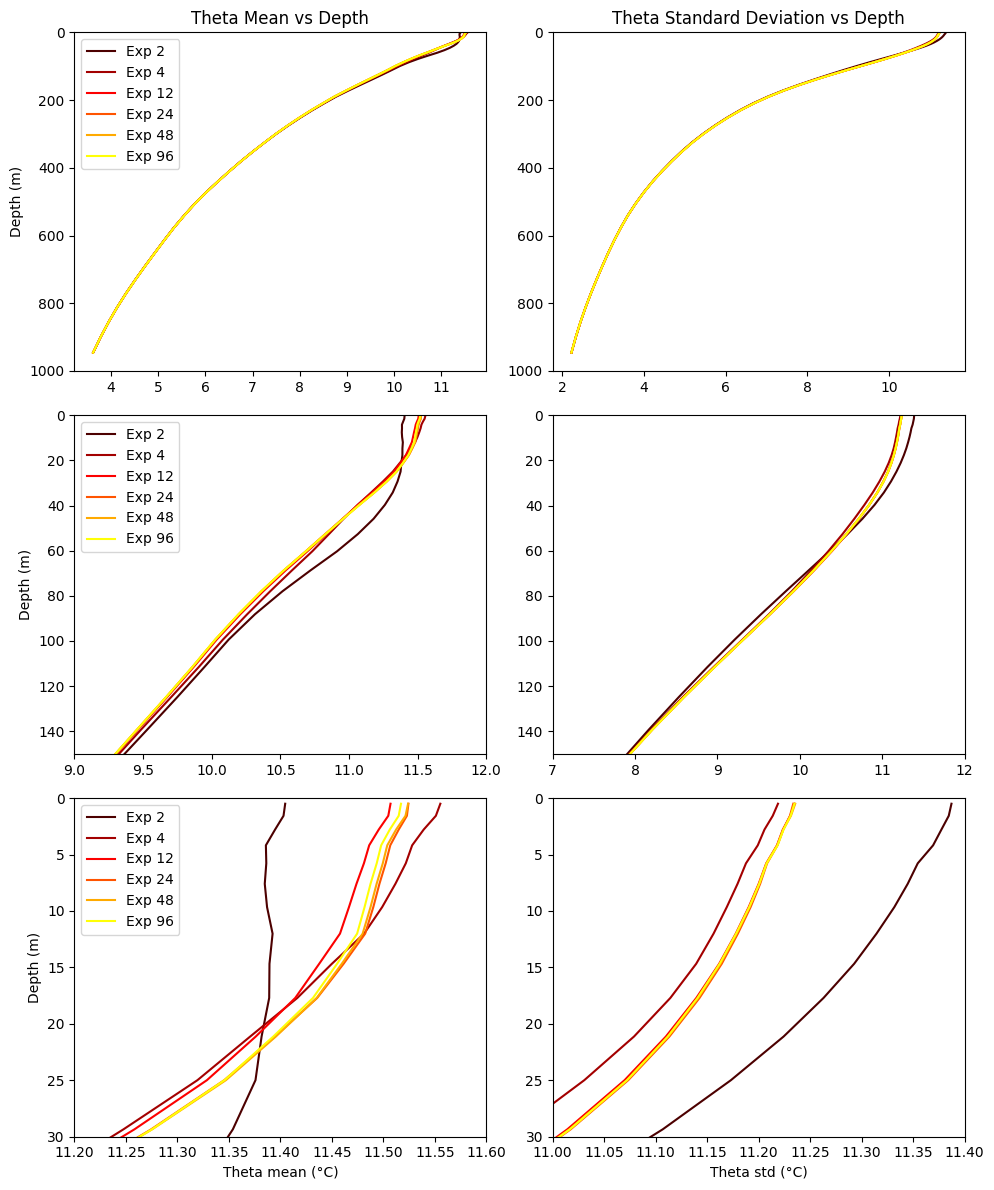

In [ ]:
theta_means = depth_mean['Theta']
theta_stds = depth_std['Theta']
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharey=False)

colors = plt.cm.hot(np.linspace(.1, .75, len(experiments)))

# --- Plot means ---
for exp, color in zip(experiments, colors):
    axes[0,0].plot(theta_means[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

axes[0,0].set_ylabel("Depth (m)")
axes[0,0].legend()
axes[0,0].set_title("Theta Mean vs Depth")
axes[0,0].set_ylim(1000,0)

# --- Plot stds ---
for exp, color in zip(experiments, colors):
    axes[0,1].plot(theta_stds[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

axes[0,1].set_title("Theta Standard Deviation vs Depth")
axes[0,1].set_ylim(1000,0)

# zoom 1
# --- Plot means ---
for exp, color in zip(experiments, colors):
    axes[1,0].plot(theta_means[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

axes[1,0].set_xlim(9,12)
axes[1,0].set_ylabel("Depth (m)")
axes[1,0].set_ylim(150,0)
axes[1,0].legend()

# --- Plot stds ---
for exp, color in zip(experiments, colors):
    axes[1,1].plot(theta_stds[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
axes[1,1].set_xlim(7,12)
axes[1,1].set_ylim(150,0)

# zoom 2
# --- Plot means ---
for exp, color in zip(experiments, colors):
    axes[2,0].plot(theta_means[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

axes[2,0].set_ylabel("Depth (m)")
axes[2,0].set_xlim(11.2,11.6)
axes[2,0].set_ylim(30,0)
axes[2,0].set_xlabel("Theta mean (°C)")
axes[2,0].legend(loc='upper left')

# --- Plot stds ---
for exp, color in zip(experiments, colors):
    axes[2,1].plot(theta_stds[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

axes[2,1].set_xlim(11, 11.4)
axes[2,1].set_ylim(30,0)
axes[2,1].set_xlabel("Theta std (°C)")

plt.tight_layout()
plt.show()

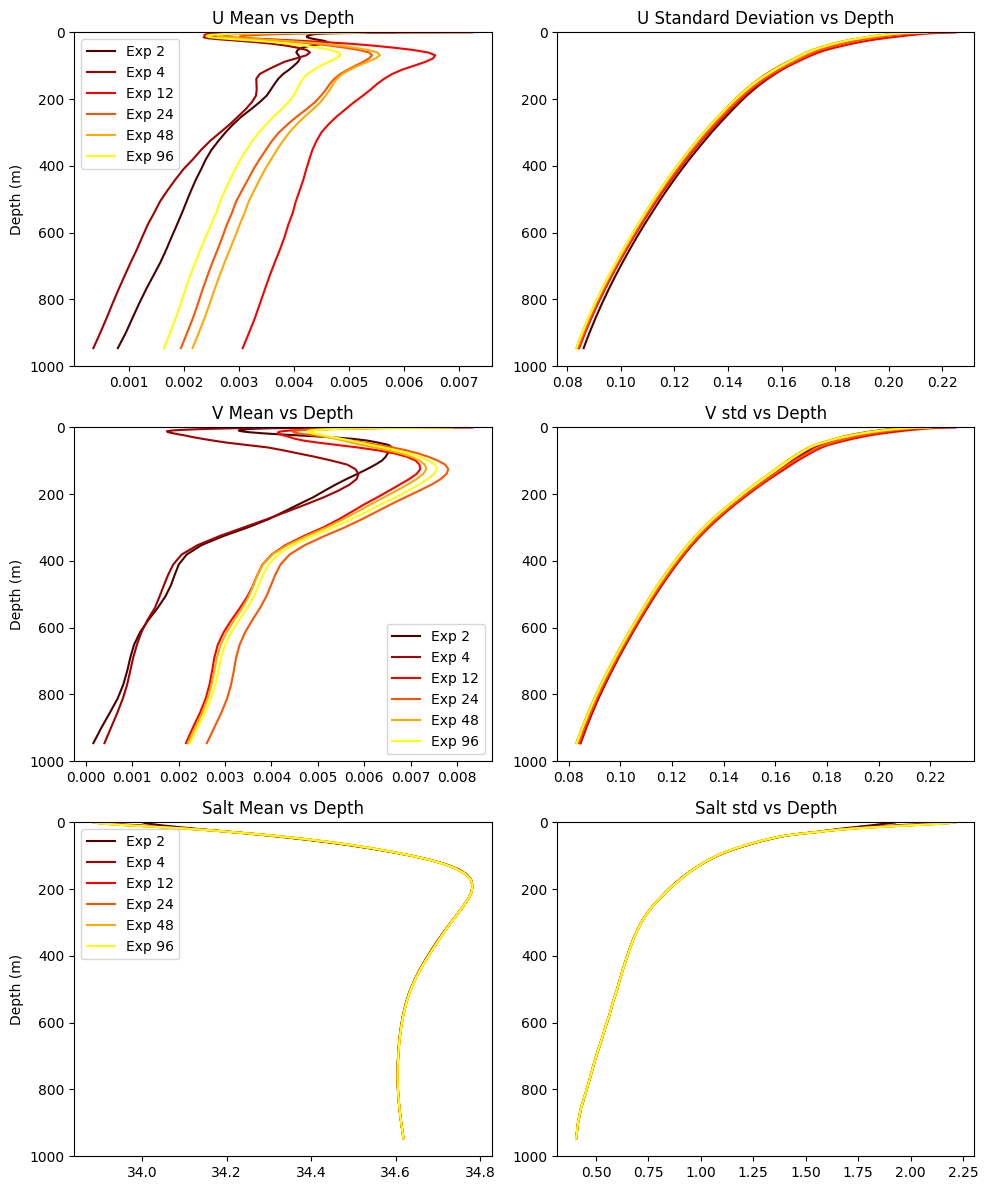

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharey=False)

colors = plt.cm.hot(np.linspace(.1, .75, len(experiments)))

# --- Plot means ---
for exp, color in zip(experiments, colors):
    axes[0,0].plot(depth_mean['U_'][f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

axes[0,0].set_ylabel("Depth (m)")
axes[0,0].legend()
axes[0,0].set_title("U Mean vs Depth")
axes[0,0].set_ylim(1000,0)

# --- Plot stds ---
for exp, color in zip(experiments, colors):
    axes[0,1].plot(depth_std['U_'][f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

axes[0,1].set_title("U Standard Deviation vs Depth")
axes[0,1].set_ylim(1000,0)

# zoom 1
# --- Plot means ---
for exp, color in zip(experiments, colors):
    axes[1,0].plot(depth_mean['V_'][f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

#axes[1,0].set_xlim(9,12)
axes[1,0].set_ylabel("Depth (m)")
axes[1,0].set_ylim(1000,0)
axes[1,0].set_title("V Mean vs Depth")
axes[1,0].legend()

# --- Plot stds ---
for exp, color in zip(experiments, colors):
    axes[1,1].plot(depth_std['V_'][f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
#axes[1,1].set_xlim(7,12)
axes[1,1].set_ylim(1000,0)
axes[1,1].set_title("V std vs Depth")

# zoom 2
# --- Plot means ---
for exp, color in zip(experiments, colors):
    axes[2,0].plot(depth_mean['Salt'][f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

axes[2,0].set_ylabel("Depth (m)")
axes[2,0].set_title("Salt Mean vs Depth")
#axes[2,0].set_xlim(11.2,11.6)
axes[2,0].set_ylim(1000,0)
#axes[2,0].set_xlabel("Theta mean (°C)")
axes[2,0].legend(loc='upper left')

# --- Plot stds ---
for exp, color in zip(experiments, colors):
    axes[2,1].plot(depth_std['Salt'][f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')

#axes[2,1].set_xlim(11, 11.4)
axes[2,1].set_title("Salt std vs Depth")
axes[2,1].set_ylim(1000,0)
#axes[2,1].set_xlabel("Theta std (°C)")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'U mean vs depth, zoom')

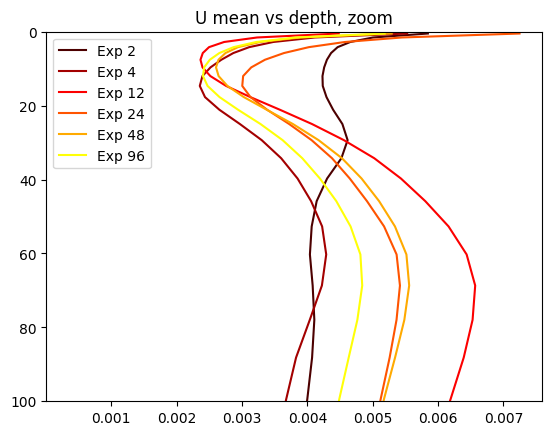

In [ ]:
for exp, color in zip(experiments, colors):
    plt.plot(depth_mean['U_'][f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
plt.ylim(100,0)
plt.legend(loc = 'upper left')
plt.title('U mean vs depth, zoom')

Text(0.5, 1.0, 'V mean vs depth, zoom')

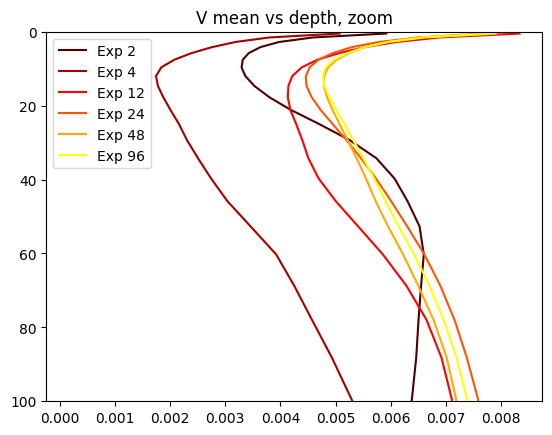

In [ ]:
for exp, color in zip(experiments, colors):
    plt.plot(depth_mean['V_'][f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
plt.ylim(100,0)
plt.legend(loc = 'upper left')
plt.title('V mean vs depth, zoom')

In [ ]:
experiments

[2, 4, 12, 24, 48, 96]

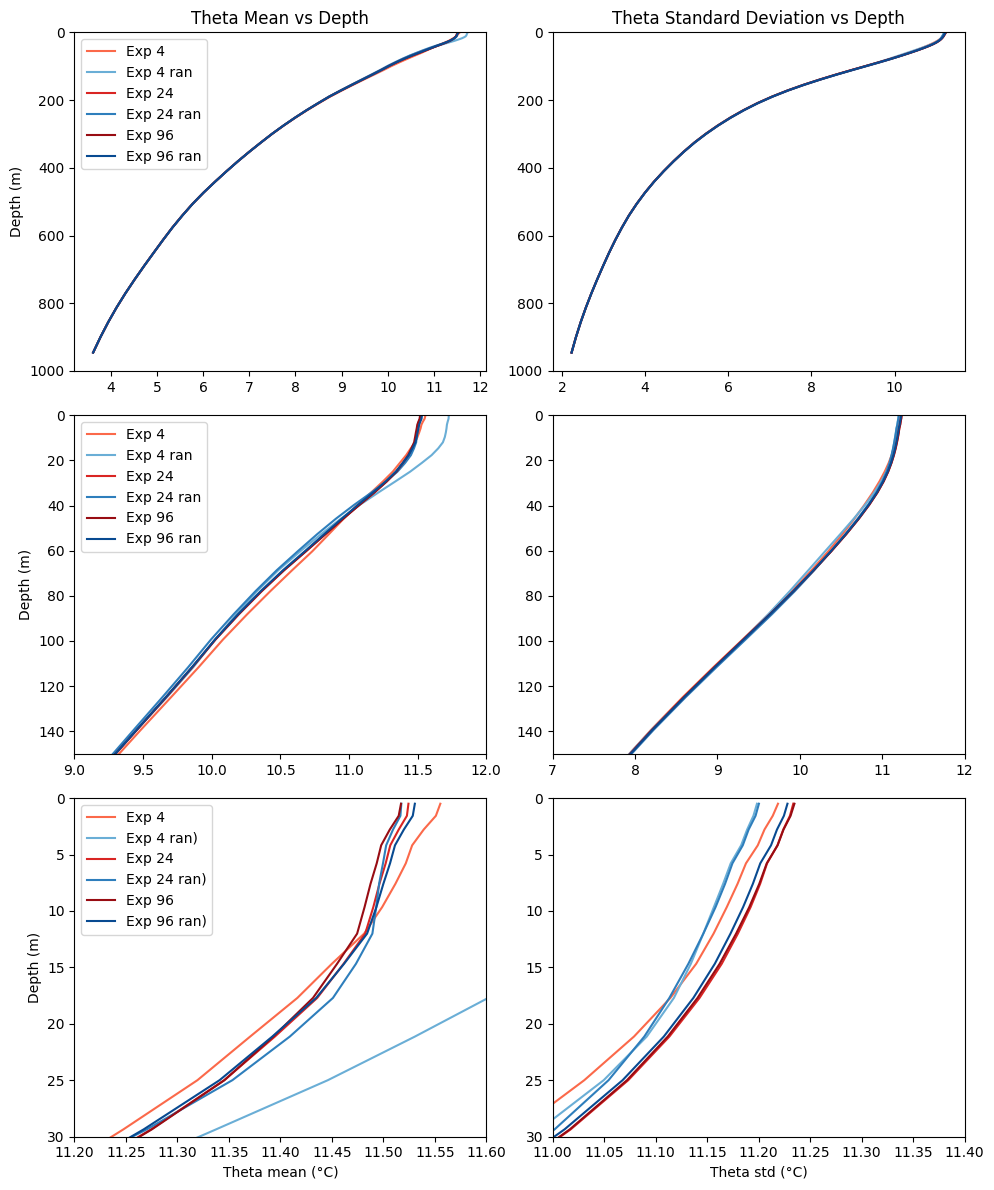

In [ ]:
selected_experiments = [experiments[1],experiments[3],experiments[5]]
theta_means = depth_mean['Theta']
theta_stds = depth_std['Theta']
fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharey=False)

colors = plt.cm.Reds(np.linspace(.5, .9, len(selected_experiments)))
colors_ran = plt.cm.Blues(np.linspace(.5, .9, len(selected_experiments)))

# --- Plot means ---
for exp, color, color_ran in zip(selected_experiments, colors, colors_ran):
    axes[0,0].plot(theta_means[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
    axes[0,0].plot(depth_mean_ran['Theta'][f'exp_{exp}'], np.abs(depths), c=color_ran, label=f'Exp {exp} ran')

axes[0,0].set_ylabel("Depth (m)")
axes[0,0].legend()
axes[0,0].set_title("Theta Mean vs Depth")
axes[0,0].set_ylim(1000,0)

# --- Plot stds ---
for exp, color, color_ran in zip(selected_experiments, colors, colors_ran):
    axes[0,1].plot(theta_stds[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
    axes[0,1].plot(depth_std_ran['Theta'][f'exp_{exp}'], np.abs(depths), c=color_ran, label=f'Exp {exp} ran')

axes[0,1].set_title("Theta Standard Deviation vs Depth")
axes[0,1].set_ylim(1000,0)

# zoom 1
# --- Plot means ---
for exp, color, color_ran in zip(selected_experiments, colors, colors_ran):
    axes[1,0].plot(theta_means[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
    axes[1,0].plot(depth_mean_ran['Theta'][f'exp_{exp}'], np.abs(depths), c=color_ran, label=f'Exp {exp} ran')

axes[1,0].set_xlim(9,12)
axes[1,0].set_ylabel("Depth (m)")
axes[1,0].set_ylim(150,0)
axes[1,0].legend()

# --- Plot stds ---
for exp, color, color_ran in zip(selected_experiments, colors, colors_ran):
    axes[1,1].plot(theta_stds[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
    axes[1,1].plot(depth_std_ran['Theta'][f'exp_{exp}'], np.abs(depths), c=color_ran, label=f'Exp {exp} ran')
axes[1,1].set_xlim(7,12)
axes[1,1].set_ylim(150,0)

# zoom 2
# --- Plot means ---
for exp, color, color_ran in zip(selected_experiments, colors, colors_ran):
    axes[2,0].plot(theta_means[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
    axes[2,0].plot(depth_mean_ran['Theta'][f'exp_{exp}'], np.abs(depths), c=color_ran, label=f'Exp {exp} ran)')

axes[2,0].set_ylabel("Depth (m)")
axes[2,0].set_xlim(11.2,11.6)
axes[2,0].set_ylim(30,0)
axes[2,0].set_xlabel("Theta mean (°C)")
axes[2,0].legend(loc='upper left')

# --- Plot stds ---
for exp, color, color_ran in zip(selected_experiments, colors, colors_ran):
    axes[2,1].plot(theta_stds[f'exp_{exp}'], np.abs(depths), c=color, label=f'Exp {exp}')
    axes[2,1].plot(depth_std_ran['Theta'][f'exp_{exp}'], np.abs(depths), c=color_ran, label=f'Exp {exp} ran')
axes[2,1].set_xlim(11, 11.4)
axes[2,1].set_ylim(30,0)
axes[2,1].set_xlabel("Theta std (°C)")

plt.tight_layout()
plt.show()

Surface Features

In [ ]:
print(mean['exp_2']['Eta'].values)

-0.29470512


In [ ]:
mean['exp_2']

<xarray.Dataset> Size: 832B
Dimensions:       ()
Data variables: (12/208)
    Salt_lev_36   float32 4B ...
    U_lev_10      float32 4B ...
    V_lev_18      float32 4B ...
    V_lev_20      float32 4B ...
    Salt_lev_41   float32 4B ...
    U_lev_28      float32 4B ...
    ...            ...
    Theta_lev_44  float32 4B ...
    Theta_lev_33  float32 4B ...
    Salt_lev_49   float32 4B ...
    U_lev_18      float32 4B ...
    Theta_lev_39  float32 4B ...
    V_lev_28      float32 4B ...

In [ ]:
experiments

[2, 4, 12, 24, 48, 96]

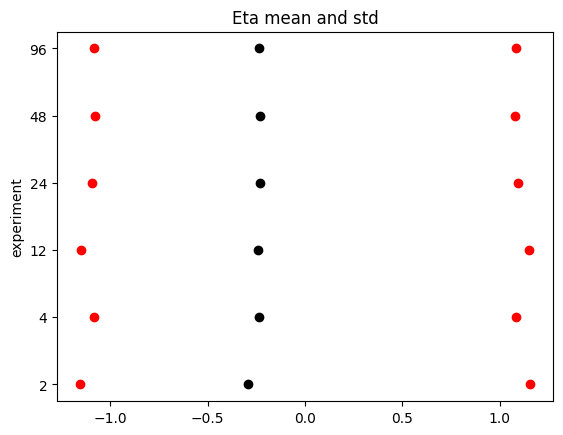

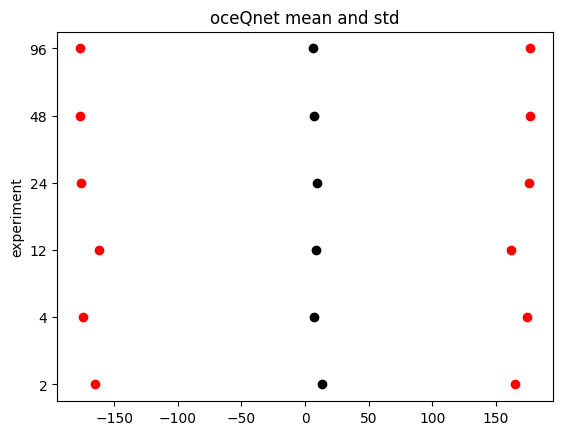

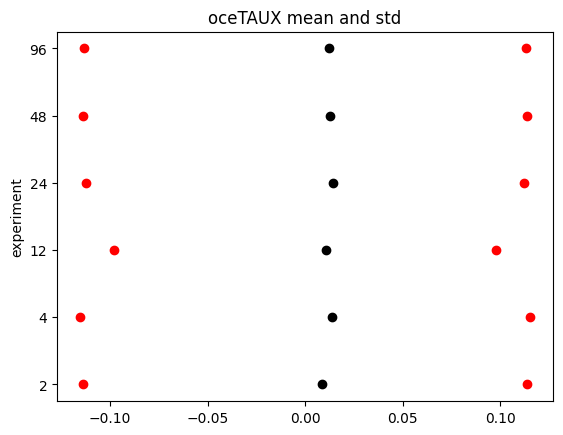

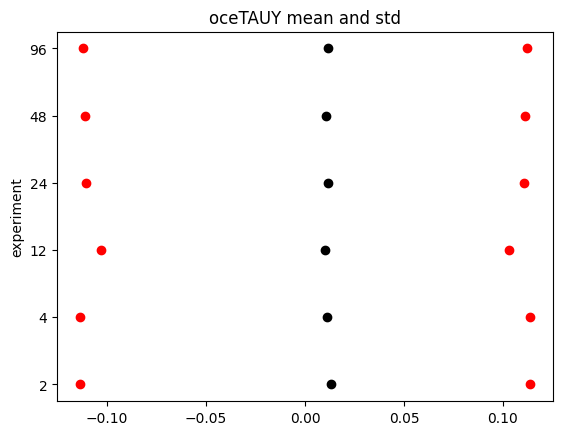

In [ ]:
SF = ['Eta', 'oceQnet', 'oceTAUX', 'oceTAUY']
y = np.linspace(0,1,6)
for feature in SF:
    for i, exp in enumerate(experiments):
        plt.scatter(mean[f'exp_{exp}'][feature].values, y[i], c = 'k')
        plt.scatter(std[f'exp_{exp}'][feature].values, y[i], c = 'r')
        plt.scatter(-std[f'exp_{exp}'][feature].values, y[i], c = 'r')
    plt.title(f'{feature} mean and std')
    plt.yticks(ticks = y, labels = [exp for exp in experiments])
    plt.ylabel('experiment')
    plt.show()

In [ ]:
SF = ['Eta', 'oceQnet', 'oceTAUX', 'oceTAUY']
for feature in SF:
    print(f'{feature}: ')
    for exp in experiments:
        print(f'mean w/ {exp} time samples: {np.round(mean[f'exp_{exp}'][feature].values,1)}')
        print(f'std w/ {exp} time samples: {np.round(std[f'exp_{exp}'][feature].values,1)}')
    print('')

Eta: 
mean w/ 2 time samples: -0.30000001192092896
std w/ 2 time samples: 1.2000000476837158
mean w/ 4 time samples: -0.20000000298023224
std w/ 4 time samples: 1.100000023841858
mean w/ 12 time samples: -0.20000000298023224
std w/ 12 time samples: 1.2000000476837158
mean w/ 24 time samples: -0.20000000298023224
std w/ 24 time samples: 1.100000023841858
mean w/ 48 time samples: -0.20000000298023224
std w/ 48 time samples: 1.100000023841858
mean w/ 96 time samples: -0.20000000298023224
std w/ 96 time samples: 1.100000023841858

oceQnet: 
mean w/ 2 time samples: 13.300000190734863
std w/ 2 time samples: 165.3000030517578
mean w/ 4 time samples: 6.900000095367432
std w/ 4 time samples: 174.5
mean w/ 12 time samples: 8.699999809265137
std w/ 12 time samples: 161.89999389648438
mean w/ 24 time samples: 9.399999618530273
std w/ 24 time samples: 176.39999389648438
mean w/ 48 time samples: 7.400000095367432
std w/ 48 time samples: 177.1999969482422
mean w/ 96 time samples: 6.199999809265137
st

In [ ]:
np.random.randint(0,100,1)

array([14])

In [ ]:

n = 58
indices = np.linspace(0, 10311, n+2, dtype=int)[1:-1]
dif = indices[1]-indices[0]
for i, val in enumerate(indices):
    offset = np.random.randint(int(-dif/2.5), int(dif/2.5))
    indices[i] = val + offset

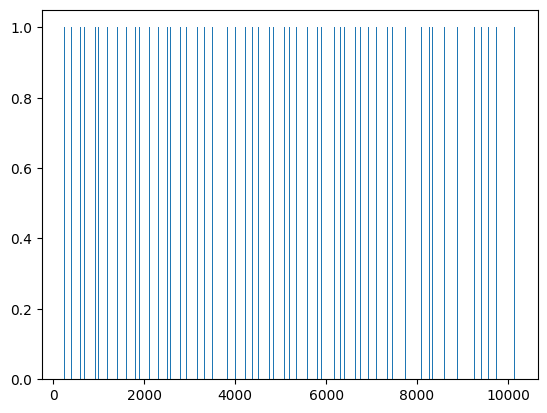

In [ ]:
plt.hist(indices,bins=500)
plt.show()

In [ ]:
np.arange(0, 10311, 108)[:96]

array([    0,   108,   216,   324,   432,   540,   648,   756,   864,
         972,  1080,  1188,  1296,  1404,  1512,  1620,  1728,  1836,
        1944,  2052,  2160,  2268,  2376,  2484,  2592,  2700,  2808,
        2916,  3024,  3132,  3240,  3348,  3456,  3564,  3672,  3780,
        3888,  3996,  4104,  4212,  4320,  4428,  4536,  4644,  4752,
        4860,  4968,  5076,  5184,  5292,  5400,  5508,  5616,  5724,
        5832,  5940,  6048,  6156,  6264,  6372,  6480,  6588,  6696,
        6804,  6912,  7020,  7128,  7236,  7344,  7452,  7560,  7668,
        7776,  7884,  7992,  8100,  8208,  8316,  8424,  8532,  8640,
        8748,  8856,  8964,  9072,  9180,  9288,  9396,  9504,  9612,
        9720,  9828,  9936, 10044, 10152, 10260])

In [ ]:
LLC

<xarray.Dataset> Size: 3PB
Dimensions:   (time: 10311, face: 13, j: 4320, i: 4320, k: 51, j_g: 4320,
               i_g: 4320, k_l: 51, k_p1: 52, k_u: 51)
Coordinates:
  * i         (i) int16 9kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g       (j_g) int16 9kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * j         (j) int16 9kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g       (i_g) int16 9kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * k_u       (k_u) int64 408B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * k_l       (k_l) int64 408B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * time      (time) datetime64[ns] 82kB 2011-09-13 ... 2012-11-15T14:00:00
  * face      (face) int16 26B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k         (k) int16 102B 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_p1      (k_p1) int64 416B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51
Data variables: (12/55)
    SIarea    (time, face, j, i) float32 10TB dask.array<chunksize=(1, 13, 4320, 4320), meta=np.ndarray>
    hFacS     (k, face, j_g, i) float32 49GB dask.array<chunksize=(51, 1, 720, 720), meta=np.ndarray>
    dyG       (face, j, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    PHrefC    (k) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    Zl        (k_l) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>
    Depth     (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    ...        ...
    W         (time, k_p1, face, j, i) float32 520TB dask.array<chunksize=(1, 52, 1, 720, 720), meta=np.ndarray>
    XG        (face, j_g, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    dxF       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    SIvice    (time, face, j_g, i) float32 10TB dask.array<chunksize=(1, 13, 4320, 4320), meta=np.ndarray>
    Eta       (time, face, j, i) float32 10TB dask.array<chunksize=(1, 13, 4320, 4320), meta=np.ndarray>
    rhoRef    (k) float32 204B dask.array<chunksize=(51,), meta=np.ndarray>

In [ ]:
(LLC['time'][1]-LLC['time'][0]).values

np.timedelta64(3600000000000,'ns')

In [ ]:
LLC['time'][0]

<xarray.DataArray 'time' ()> Size: 8B
array('2011-09-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2011-09-13

In [ ]:
37116000000000000 *( 1.157 * 10 **(-14))

429.43212

In [ ]:
365/430

0.8488372093023255

In [ ]:
LLC['time'][-1] - LLC['time'][0]

<xarray.DataArray 'time' ()> Size: 8B
array(37116000000000000, dtype='timedelta64[ns]')

In [ ]:
testing = LLC.isel(face = 1, time = 1)

In [ ]:
oceTAUX', 'oceTAUY'

In [ ]:
test_mean = testing['oceTAUX'].mean(skipna=True, dim=['j', 'i_g'])

In [ ]:
test_mean = testing['W'].mean(skipna=True, dim=['j', 'i'])
test_depth = test_mean.isel(k_p1=1).reset_coords(drop=True)
test_depth

<xarray.DataArray 'W' ()> Size: 4B
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [ ]:
test_mean

<xarray.DataArray 'U' ()> Size: 4B
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2011-09-13T01:00:00
    face     int16 2B 1
    k        int16 2B 0

In [ ]:
# define features
surface_features = ['Eta', 'oceQnet', 'oceTAUX', 'oceTAUY']
ubiquitous_features = ['U', 'V', 'W', 'Theta', 'Salt']

In [ ]:
LLC['U'].shape

(10311, 51, 13, 4320, 4320)

In [ ]:
LLC['Eta'].shape

(10311, 13, 4320, 4320)

In [ ]:
# select random time indices
length = len(LLC[ubiquitous_features[0]].time)-1
num_samples = 2 # must be less than length
assert length >= num_samples

time_samples = np.random.randint(low = 0, high = length, size = num_samples)

# define depths
depth_extent = len(LLC[ubiquitous_features[0]].k)

In [ ]:
# sample LLC temporal subset
LLC_sampled = xr.concat([LLC.isel(k = slice(0, depth_extent), time = t) for t in time_samples], dim = "time_sampled")
#LLC_chunked = LLC_sampled.chunk({'face': 1, 'j': 80, 'i': 80, 'time_sampled': -1})

In [ ]:
test = [LLC_sampled[f] for f in ubiquitous_features]

In [ ]:
testing = LLC_sampled.isel(face=2, k = 0)['Theta'].mean(dim=['time_sampled','j','i'])

In [ ]:
testing.load()

<xarray.DataArray 'Theta' ()> Size: 4B
array(15.127071, dtype=float32)
Coordinates:
    face     int16 2B 2
    k        int16 2B 0

In [ ]:
test[2]

<xarray.DataArray 'W' (time_sampled: 2, k_p1: 52, face: 13, j: 4320, i: 4320)> Size: 101GB
dask.array<concatenate, shape=(2, 52, 13, 4320, 4320), dtype=float32, chunksize=(1, 52, 1, 720, 720), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int16 9kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int16 9kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
    time     (time_sampled) datetime64[ns] 16B 2012-07-11T22:00:00 2011-10-18...
  * face     (face) int16 26B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * k_p1     (k_p1) int64 416B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51
Dimensions without coordinates: time_sampled
Attributes:
    long_name:      Vertical Component of Velocity
    standard_name:  sea_water_z_velocity
    units:          m s-1

In [ ]:
face = 8
k = 0
time = 100

mean_test = (LLC.isel(face = face, k = k, time = time)).mean()
std_test = (LLC.isel(face = face, k = k, time = time)).std()

In [ ]:
print(np.array(mean_test.Theta))
print(np.array(std_test.Theta))

18.626717
8.688425


In [ ]:
# let's explore the temporal bounds of LLC data as datetime
print(f'first datetime: {LLC.time[0].values.astype('datetime64')}')
print(f'last datetime: {LLC.time[10310].values.astype('datetime64')}')
print(f'difference: {LLC.time[10310].values.astype('datetime64') - LLC.time[0].values.astype('datetime64')}')

first datetime: 2011-09-13T00:00:00.000000000
last datetime: 2012-11-15T14:00:00.000000000
difference: 37116000000000000 nanoseconds


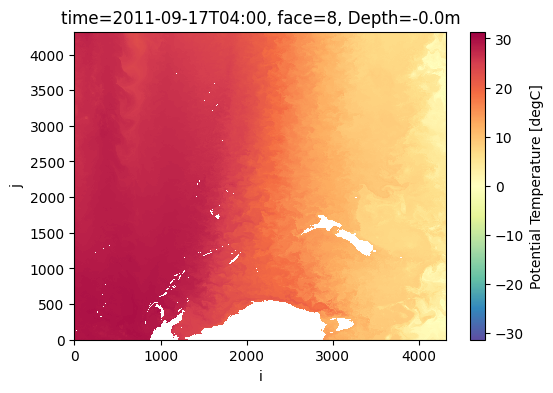

In [ ]:
# let's plot the subset
j = slice(0,4320)
i = slice(0,4320)

plt.figure(figsize=(6,4),dpi=100)
LLC.Theta.isel(time=time,k=k,face=face,j=j,i=i).plot(cmap="Spectral_r")
plt.title(f"time={LLC.Theta.time[time].values.astype('datetime64[m]')}, face={face}, Depth={np.around(LLC.Z.values[k])}m")
#plt.savefig(f"./movie_figs/face02_time_k13/face{str(face).zfill(2)}_time{str(time).zfill(6)}_k{k}.png")
plt.show()

NameError: name 'LLC' is not defined